#### calculate Phenomena Contribution to Mean and Heavy Precipitation
- each phenomenon's precipitation to total annual precipitation  
- the top 99th percentile hourly precipitation events at each grid cell

Ming Ge: According to Andy's paper
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023EF003534

In [1]:
import numpy as np
import xarray as xr
import string

from netCDF4 import Dataset
import glob
import os
 
from pdb import set_trace as stop
 
import scipy
from scipy import ndimage
from scipy.ndimage import label

from pylab import *

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# from mpl_toolkits.basemap import Basemap, cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from Tracking_Functions import overlapping_objects

In [2]:
def plot_ext_p3(title, ObjectsSort, AnnualMCSFrequency, data_collection):
    '''
    ObjectsSort = ['MCSs', 'MCS_PR', 'MCS_EPR'] 
    '''
    
    Frequency = ['#f9faee','#59539b','#4186b4','#78bca7','#b4d8a8','#ebf2a5','#fffec9','#f8e097','#f3b272','#e1774c','#c44a54','#ea43f1']
    PR_Fraction = ['#ffffff','#ffffff','#afdbef','#5a96c6','#64ab5f','#eadf6d','#e9813d','#c93d35','#962722',
              '#7a0177','#c51b8a','#f768a1','#fa9fb5'] 

    LevFreq =np.array([2, 5, 10,15,20,30,40,50,70,100,150])
    #LevFreq = np.arange(1,50,5)
    LevPR   = np.arange(1,60, 6)
    LevEPR  = np.array([5,10,25,50,75,85,95,97.5,99])

    fig = plt.figure(figsize=(20,4.5))
    rgsLableABC=list(string.ascii_lowercase)
    gs1 = gridspec.GridSpec(1,3)
    gs1.update(left=0.10, right=0.96,
               bottom=0.10, top=0.93,
               wspace=0.08, hspace=0.2)
    plt.rcParams.update({'font.size': 14})
    
    for st in range(len(ObjectsSort)):
    
        if '_PR' not in ObjectsSort[st] and '_EPR' not in ObjectsSort[st]: 
            DATA = np.copy(AnnualMCSFrequency).astype(float)/8.0
            Levels = LevFreq  
            MIN = 0.2
            Label = 'Frequency of ' + ObjectsSort[0]
            COL = Frequency
        elif '_PR' in ObjectsSort[st]:
            DATA = data_collection[0]
            Levels = LevPR #np.arange(0,102,2)
            MIN = 0.
            Label = 'Ratio of Precipitation from  ' + ObjectsSort[0] + '  [%]'
            COL = PR_Fraction
        elif '_EPR' in ObjectsSort[st]:
            DATA = data_collection[1]
            Levels = LevPR  
            MIN = 0.
            Label = 'Ratio of p99 Precipitation Events from ' + ObjectsSort[0] + ' [%]'
            COL = PR_Fraction
        
        Levels[0] = MIN

        DATA[DATA < MIN] = np.nan

        proj = ccrs.PlateCarree() #ccrs.Robinson() 
        ax = plt.subplot(gs1[0,st], projection=proj)
        pos1 = ax.get_position()
        cs = plt.contourf(Lon, Lat, DATA, transform=ccrs.PlateCarree(), levels=Levels, extend='both', colors=COL) 
        if '_PR' in ObjectsSort[st]:
            cs.cmap.set_over('#fcc5c0')
            cs.cmap.set_under('#ffffff')
        if '_EPR' in ObjectsSort[st]:
            cs.cmap.set_over('#fcc5c0')

        #
        #plt.title(rgsLableABC[st]+')'+Label)
        plt.title(Label)
        
        ax.coastlines()
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.left_labels=gl.bottom_labels = False  
        '''
        #ax.set_extent((-180, 180, -60, 60), ccrs.PlateCarree())
        if (st == 0):
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.left_labels = False
        else:
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            #gl.top_labels = gl.right_labels = gl.left_labels = gl.bottom_labels = False
            gl.left_labels = False
        '''
        # axes([ x-coordinate of the lower-left corner, y-coordinate of the lower-left corner, the width, the height])
        CbarAx = axes([pos1.x0-0.05, 0.1, pos1.width+0.10, 0.04])
        cb = colorbar(cs, cax = CbarAx, orientation='horizontal',  ticks=Levels)
        #cb.set_label(title) #, fontsize=12)
        fig.suptitle(title, y=1)
        

In [3]:
def plot_2d(lat, lon, data_2d, color_map, title_s):
    fig = plt.figure(figsize=(10,14))

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())
    
    # Make a filled contour plot
    filled_c = ax.contourf(lon, lat, data_2d,
                           levels =np.arange(0, 51, 5), extend='both',
                           cmap = color_map, transform = ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines()
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
    ax.set_title(title_s)
    
    ax = plt.gca()
    ax.gridlines(draw_labels=True)   
    # or..
    #ax.set_xticks([-40, -20, 0, 20, 40], crs=ccrs.PlateCarree())

    # Add a colorbar for the filled contour.
    # and pad argument to set colorbar away from x-axis
    fig.colorbar(filled_c,  label= 'mm/3hr', pad = 0.05, fraction=0.04, orientation="horizontal"); # 

In [4]:
def ax_coastlines_country(ax_s):
    ax_s.coastlines(lw=1.5, resolution='110m')
    ax_s.add_feature(cfeature.STATES.with_scale('110m'), zorder=3, linewidth=1.5, edgecolor='g')
    # mask ocean 
    ax_s.add_feature(cfeature.OCEAN, facecolor='white', zorder=1) 

def plot_p2(lat, lon, data_3d, color_map, title_s):
    fig = plt.figure(figsize=(22, 12))

    vmin = 0
     
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, "pad" : .05, 'aspect':40, 'label':'2 Metre Temperature Anomaly [K]'}
    
    for nf in range(1, 3):
        ax = fig.add_subplot(1, 2, nf, projection= ccrs.PlateCarree())

        if nf == 1:
            vmax = 50
        else: 
            vmax = 10
        level_s = np.linspace(vmin, vmax, 11) 
        
        mm = plt.contourf(lon, lat, data_3d[nf-1], 
                      cmap = color_map, extend='both',
                      vmin = vmin, vmax = vmax, levels = level_s,
                      transform=ccrs.PlateCarree())
        
        ax.coastlines()
        ax_coastlines_country(ax)
        
        plt.colorbar(mm, orientation='horizontal', pad=0.05)    
     
        gl = ax.gridlines(draw_labels=True)   
        gl.xlines = gl.ylines = False

        plt.title(title_s, fontweight="bold",fontsize=14)


#### Mask

In [5]:
# Target grid resolusion
res_TarGrid = '44'
dir_obj = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.'+res_TarGrid+'/'

# target grid is generated by - ~/projects/FRONTIER/programs/CommonGrids/CommonGrids.ipynb
TargetGrid = '/glade/u/home/prein/projects/FRONTIER/programs/CommonGrids/Regular_0.' + res_TarGrid +'_EURO-CORDEX.nc'
# ### Read the target grid
ncid=Dataset(TargetGrid, mode='r')
Lat=np.squeeze(ncid.variables['lat'][:])
Lon=np.squeeze(ncid.variables['lon'][:])
Mask=np.squeeze(ncid.variables['Mask'][:])
ncid.close()

Lon[Lon >= 180] = Lon[Lon >= 180]-360

if len(Lon.shape) == 1:
    Lon,Lat = np.meshgrid(Lon,Lat)

#  N, E, S, W
FocusRegion = [67.92, 50.06, 27, -32] 
iNorth = np.argmin(np.abs(Lat[:,0] - FocusRegion[0]))
iSouth = np.argmin(np.abs(Lat[:,0] - FocusRegion[2]))+1
iEeast = np.argmin(np.abs(Lon[0,:] - FocusRegion[1]))+1
iWest  = np.argmin(np.abs(Lon[0,:] - FocusRegion[3]))

Lon = Lon[iSouth:iNorth,iWest:iEeast]   # (371, 747)
Lat = Lat[iSouth:iNorth,iWest:iEeast]

Mask = Mask[iSouth:iNorth,iWest:iEeast]

#### setup

In [6]:
obj_1d = [ 'BT_Objects', 'ACY_Objects', 'CY_Objects', 'CY_z500_Objects', 'FR_Objects', 'JET_Objects', 'MCS_Tb_Objects', 'MS_Objects' ] # 'COL_Objects',
n_obj = len(obj_1d)

In [14]:
# data resolusion
res_EUR = 'EUR-11'
res_EUR = 'EUR-44'
res_EUR = 'CERRA'

if res_EUR == 'CERRA':
    DataDir = '/glade/campaign/mmm/c3we/CERRA/3hr/'
else:
    DataDir = '/glade/campaign/mmm/c3we/FRONTIER/data/'+ res_EUR +'/evaluation/ECMWF-ERAINT/r1i1p1/'

if res_EUR == 'EUR-44':
    DataName_1d = ['CLMcom-CCLM5-0-6_v1', 
                   'MOHC-HadGEM3-RA_v1',
                   'UCAN-WRF331G_v01']
elif res_EUR == 'EUR-11':
    # name of analyzed dataset EUR-11
    DataName_1d = ['CLMcom-ETH-COSMO-crCLIM-v1-1_v1', \
                'MOHC-HadREM3-GA7-05_v1',\
                'ICTP-RegCM4-6_v1']
else:
    DataName_1d = ['CERRA']

n_dataset = len(DataName_1d)

CL_MaxT = 230  # minimum brightness temperature

#### /glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/EUR-11/

 . CLMcom-ETH-COSMO-crCLIM-v1-1_v1/201001_CLMcom-ETH-COSMO-crCLIM-v1-1_v1_ObjectMasks__dt-3h_MOAAP-masks.nc  <br>
   BT 217-332

 . MOHC-HadREM3-GA7-05_v1/201001_MOHC-HadREM3-GA7-05_v1_ObjectMasks__dt-3h_MOAAP-masks.nc <br>
BT 227 - 339

 . ICTP-RegCM4-6_v1/ 201001_ICTP-RegCM4-6_v1_ObjectMasks__dt-3h_MOAAP-masks.nc <br>
BT 239 - 335

#### /glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/EUR-44/
 . CLMcom-CCLM5-0-6_v1/201001_CLMcom-CCLM5-0-6_v1_ObjectMasks__dt-3h_MOAAP-masks.nc <br>
BT 215-324

 . MOHC-HadGEM3-RA_v1/201001_MOHC-HadGEM3-RA_v1_ObjectMasks__dt-3h_MOAAP-masks.nc <br>
225-343

 . UCAN-WRF331G_v01/201001_UCAN-WRF331G_v01_ObjectMasks__dt-3h_MOAAP-masks.nc <br>
225-310

In [15]:
%%time

year_s = 1990
year_e = 2010
#year_s = year_e -1
n_year = year_e - year_s + 1

dir_data = '/glade/campaign/mmm/c3we/mingge/FRONTIERS/data/'
flnm_o = dir_data + 'pr_obj_stats_' + res_EUR + '_nooverlap.nc'
if os.path.exists(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        AnnualObjFrequency = ds.AnnualObjFrequency.values
        data_collection = ds.data_collection.values
else:        
    flnm_p99 = dir_data + 'prec_p99_' + res_EUR + '.nc'
    ncid=Dataset(flnm_p99, mode='r')
  
    PR_p99 = np.squeeze(ncid.variables['prec_p99'])
    Lat = np.squeeze(ncid.variables['lat_2d'][:])
    Lon = np.squeeze(ncid.variables['lon_2d'][:])
    ncid.close() 
    
    n_lat = Lat.shape[0]
    n_lon = Lat.shape[1]

    data_collection = np.zeros((n_dataset, len(obj_1d), 2, Lon.shape[0], Lon.shape[1])) 
    data_collection[:] = np.nan

    AnnualObjFrequency =  np.zeros((n_dataset, len(obj_1d), Lon.shape[0], Lon.shape[1])) 
    AnnualObjFrequency[:] = np.nan

    AnnualObj_PR =  np.zeros((len(obj_1d), Lon.shape[0], Lon.shape[1])) 
    AnnualObj_PR[:] = np.nan

    ExtrPR_annual = np.zeros((len(obj_1d), Lon.shape[0], Lon.shape[1])) 
    ExtrPR_annual[:] = np.nan

    PR_total = ExtrPR_annual.copy()
    PR_total_p99 = ExtrPR_annual.copy()

    totalObj_PR = ExtrPR_annual.copy()
    ExtrPR_total = ExtrPR_annual.copy()

    for nd in range(n_dataset):
        for year in range(year_s, year_e + 1):
            print(year)
            if res_EUR == 'CERRA':
                flnm = dir_obj + res_EUR + '/' + str(year) + '01_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc'
            else:
                flnm = dir_obj + res_EUR + '/' + DataName_1d[nd] + '/'+ str(year)+'01_'+ DataName_1d[nd] +'_ObjectMasks__dt-3h_MOAAP-masks.nc'
            print(flnm)
    
            ncid = Dataset(flnm, mode='r')
            PR   = np.squeeze(ncid.variables['PR'])
            n_time = PR.shape[0]

            data_obj = np.zeros((len(obj_1d), n_time, Lon.shape[0], Lon.shape[1])) 
            data_obj[:] = np.nan
    
            for no in range(n_obj):
                data_obj[no] = np.squeeze(ncid.variables[obj_1d[no]])
                
            ncid.close() 

            AnnualPR = np.sum(PR, axis=0)
            # get extreme (P99) PR 
            if res_EUR == 'CERRA':
                AnnualPR_p99 = np.sum((PR >= PR_p99[None,:,:]), axis=0)
            else:
                AnnualPR_p99 = np.sum((PR >= PR_p99[nd,:,:]), axis=0)  
        
            # find all Objs overlap with Tb_obj
            for no in range(n_obj):
                #obj_PR = overlapping_objects(data_obj[0], data_obj[no], PR)
                # BT_Objects impact overlapping
                obj_PR = overlapping_objects(data_obj[no], data_obj[no], PR)
                 
                AnnualObjFrequency[nd, no] = np.sum(data_obj[no] > 0, axis=0)
                AnnualObj_PR[no] = np.sum(obj_PR, axis=0)
                if res_EUR == 'CERRA':
                    ExtrPR_annual[no] = np.sum((obj_PR >= PR_p99[None,:,:]), axis=0)
                else:
                    ExtrPR_annual[no] = np.sum((obj_PR >= PR_p99[nd,:,:]), axis=0)
    
                if year == year_s :
                    PR_total[no] = AnnualPR
                    PR_total_p99[no] = AnnualPR_p99
             
                    totalObj_PR[no] = AnnualObj_PR[no]
                    ExtrPR_total[no] = ExtrPR_annual[no]
                else:
                    PR_total[no] = AnnualPR + PR_total[no]
                    PR_total_p99[no] = AnnualPR_p99 + PR_total_p99[no]

                    totalObj_PR[no] = AnnualObj_PR[no] + totalObj_PR[no]
                    ExtrPR_total[no] = ExtrPR_annual[no] + ExtrPR_total[no] 

        for no in range(n_obj):
            data_collection[nd, no, 0] = totalObj_PR[no]/PR_total[no]*100
            data_collection[nd, no, 1] = ExtrPR_total[no]/PR_total_p99[no]*100

    # Write dataset contents to a netCDF file.
    ### create and write out dataset
    AnnualObjFrequency[:, :, Mask == 0] = np.nan
    AnnualObjFrequency_xr = xr.DataArray(AnnualObjFrequency, dims=('dataset', 'obj', 'lat', 'lon'), name='AnnualObjFrequency')

    data_collection[:, :, :, Mask == 0] = np.nan
    data_collection_xr = xr.DataArray(data_collection, dims=('dataset', 'obj', 'prec-type', 'lat', 'lon'), name='AnnualObjFrequency')

    lat_xr = xr.DataArray(Lat, dims=('lat', 'lon'), name='Lat')
    lon_xr = xr.DataArray(Lon, dims=('lat', 'lon'), name='Lon') 

    ds = xr.Dataset({'AnnualObjFrequency': AnnualObjFrequency_xr, 
                 'data_collection': data_collection_xr, 
                 'prec-type': range(2),
                 'dataset': range(n_dataset), 
                 'obj': range(n_obj), 
                 'lat_2d': lat_xr, 
                 'lon_2d': lon_xr})

    print('output file:' + flnm_o)
    # create and write out dataset 
 
    ds = ds.assign_attrs(script='Ming Ge: objs_PR_EUR.ipynb',description=DataName_1d)
 
    ds.to_netcdf(flnm_o)


1990
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/199001_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc
1991
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/199101_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc
1992
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/199201_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc
1993
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/199301_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc
1994
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/199401_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc
1995
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/199501_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc
1996
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/199601_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc
1997
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regular_0.44/CERRA/199701_CERRA_ObjectMasks__dt-3h_MOAAP-masks.nc
1998
/glade/campaign/mmm/c3we/mingge/FRONTIERS/OBJS/Regu

<timed exec>:99: RuntimeWarning: invalid value encountered in divide


#### BT_Objects NO overlapping¶

#### .44

/glade/derecho/scratch/mingge/tmp/ipykernel_54245/2245666699.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20,4.5))


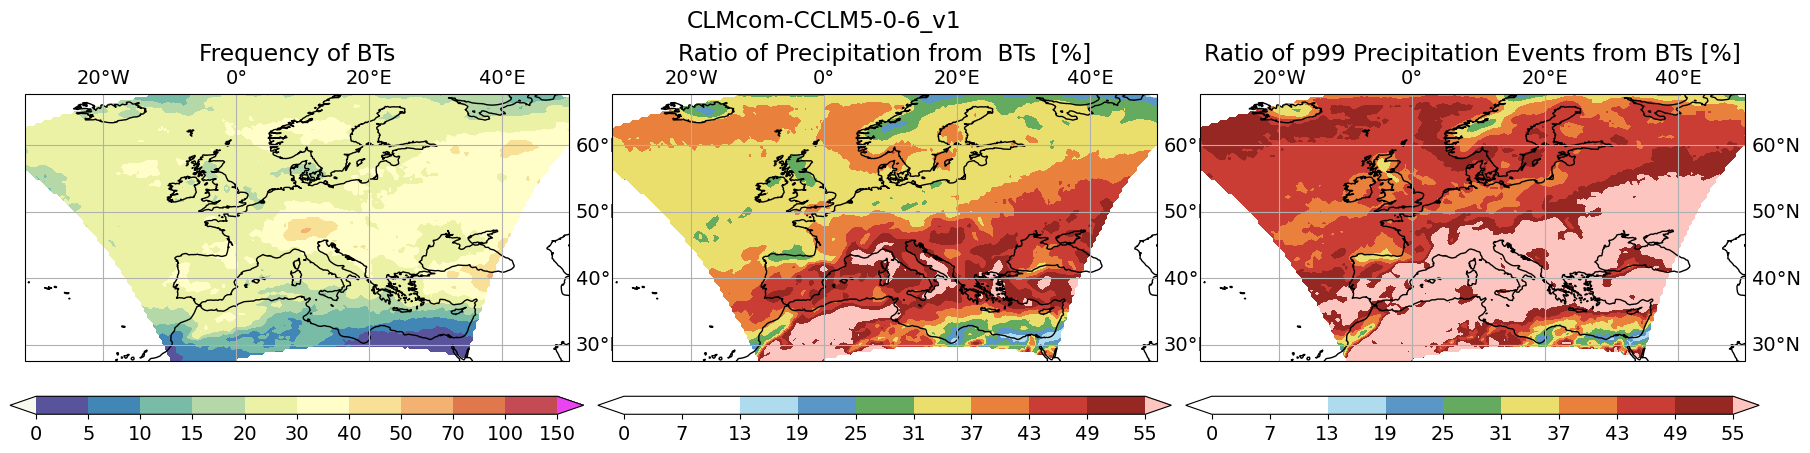

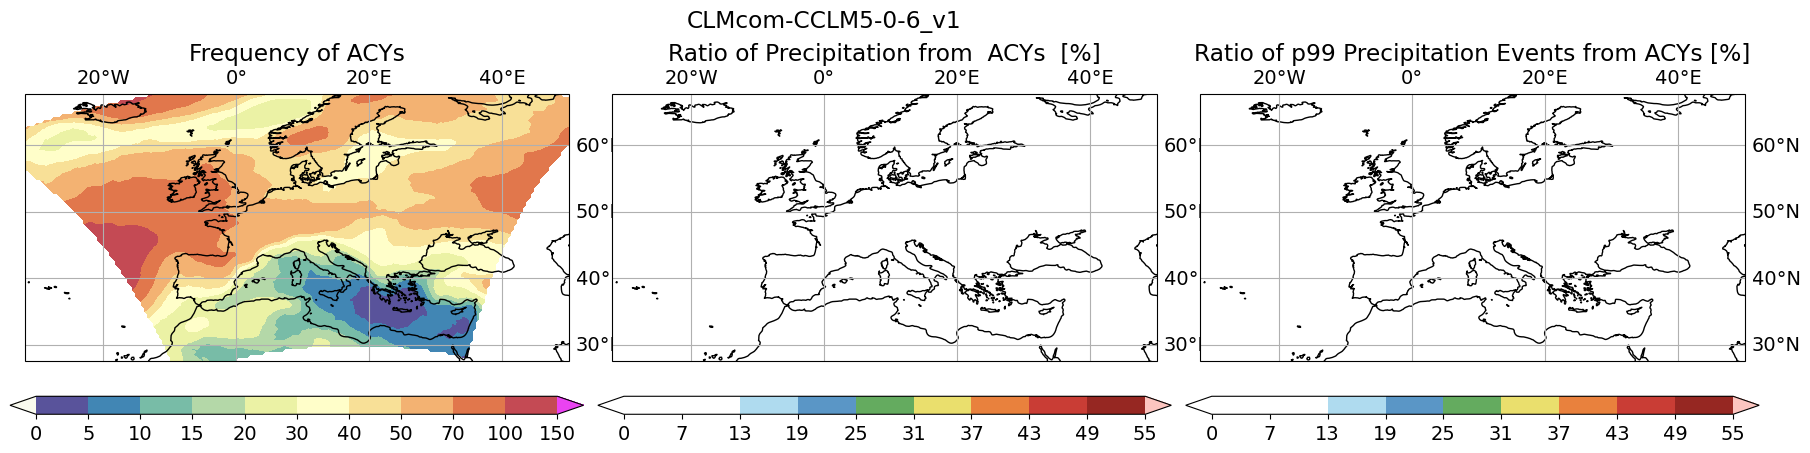

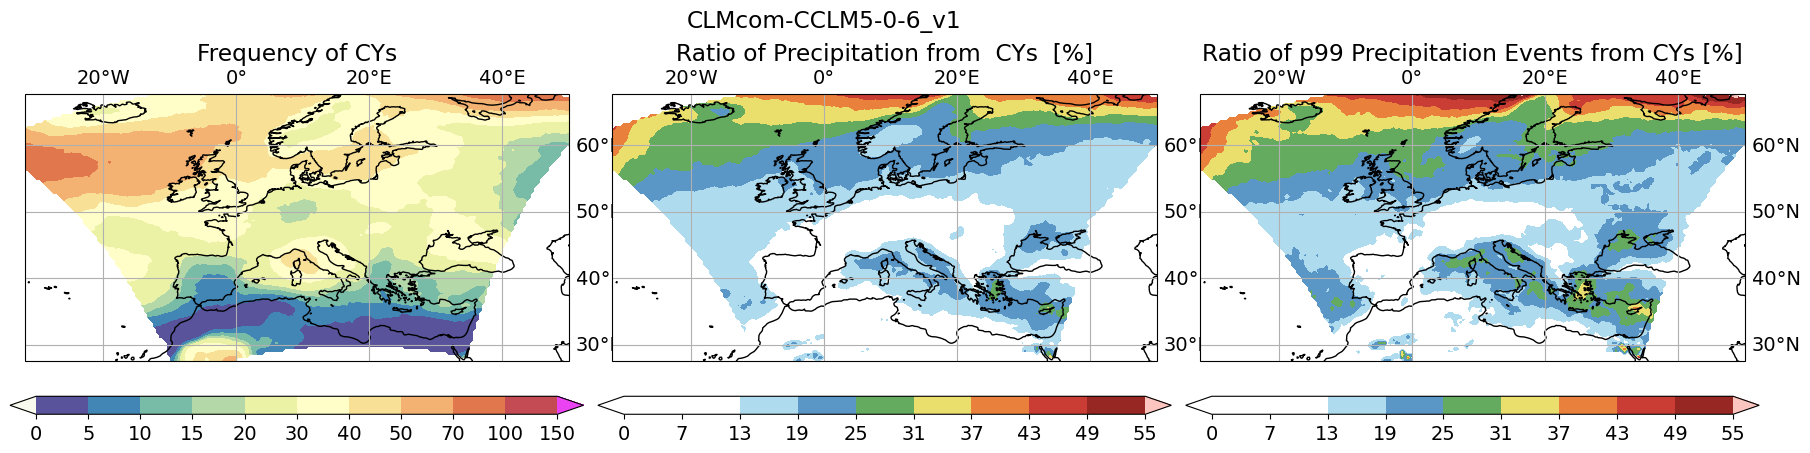

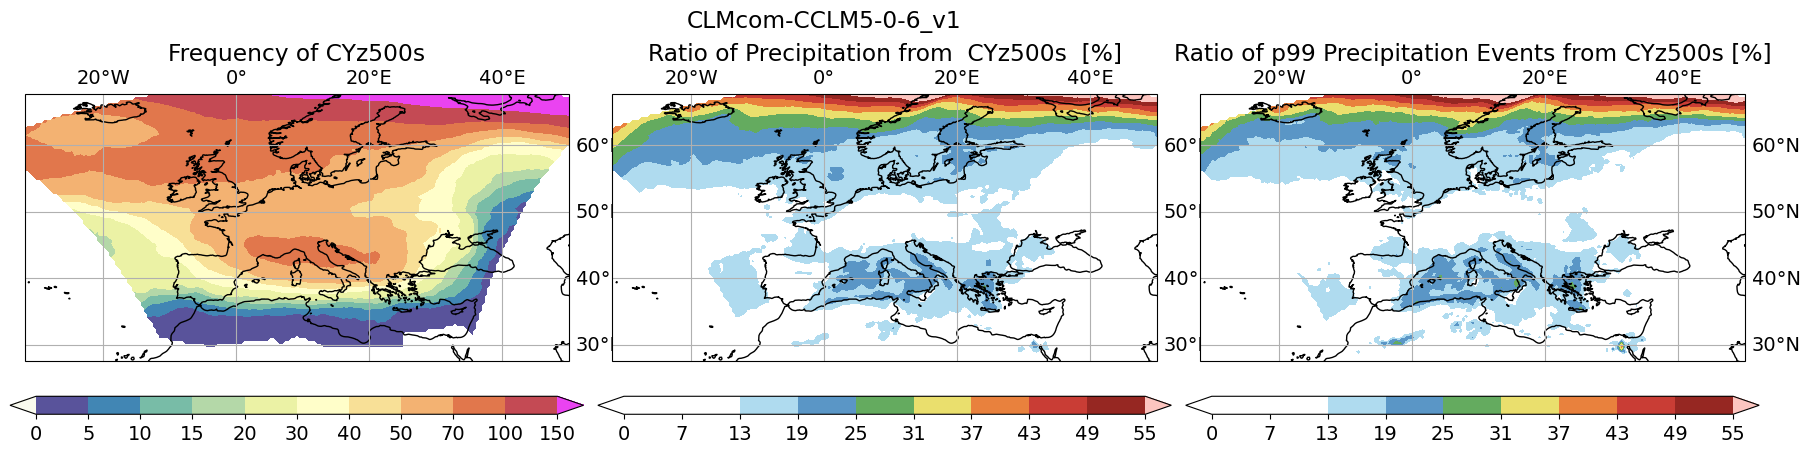

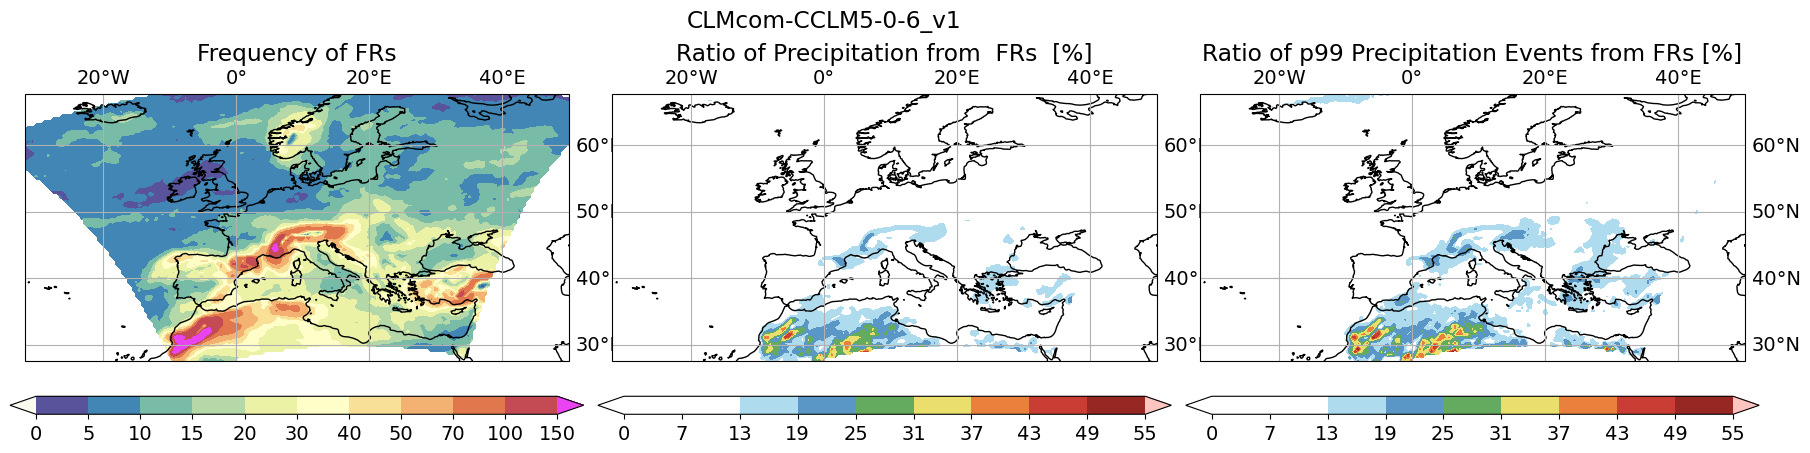

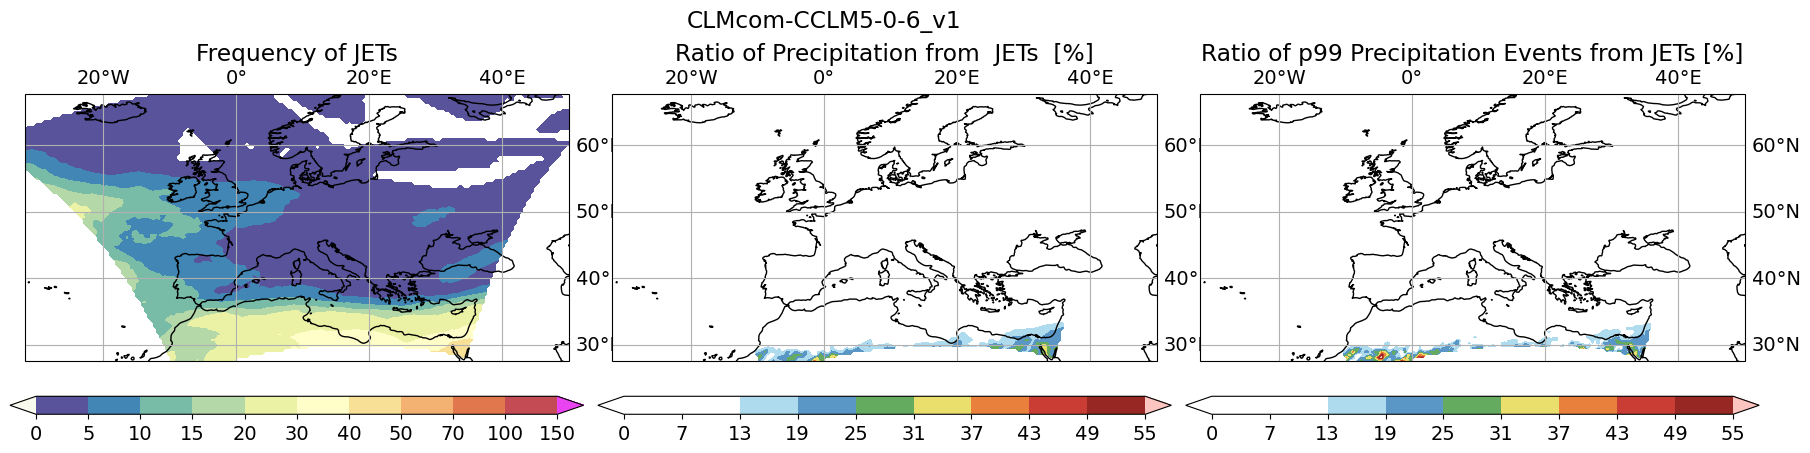

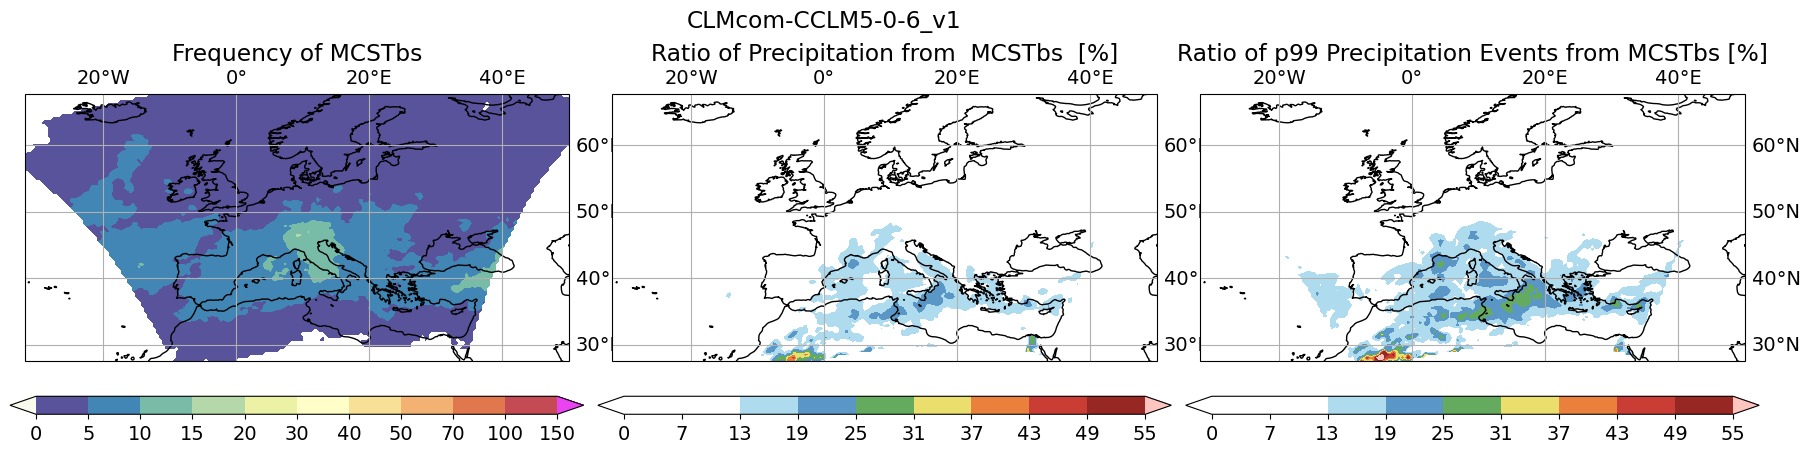

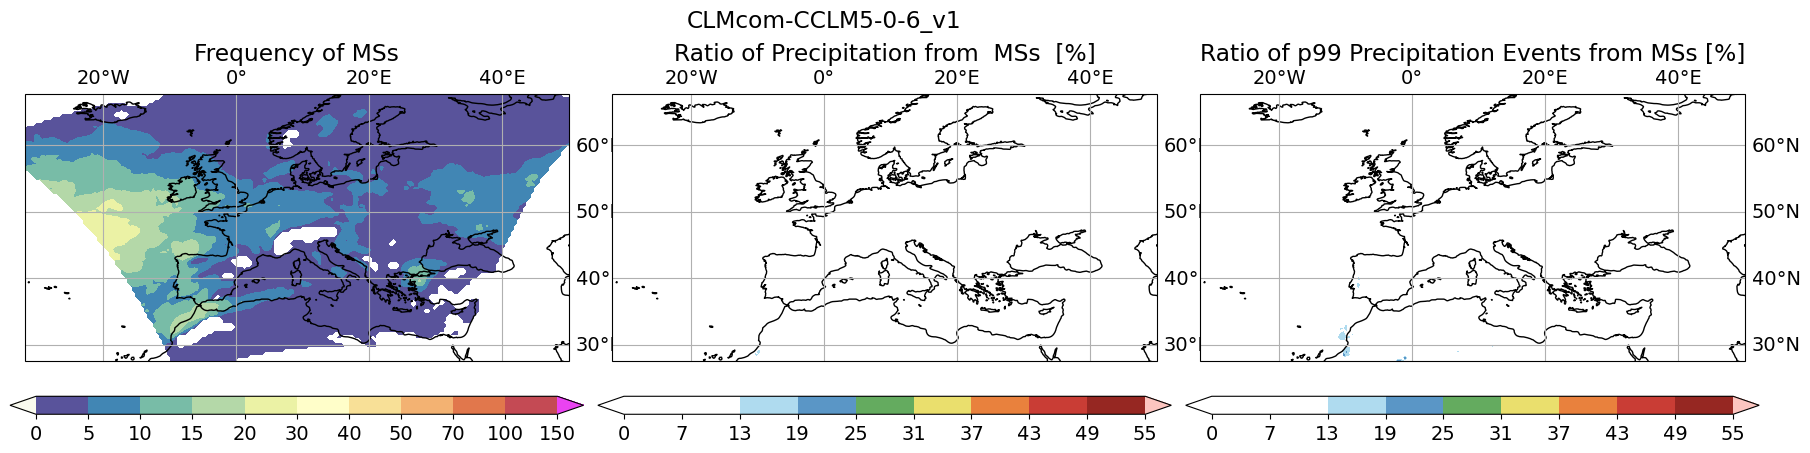

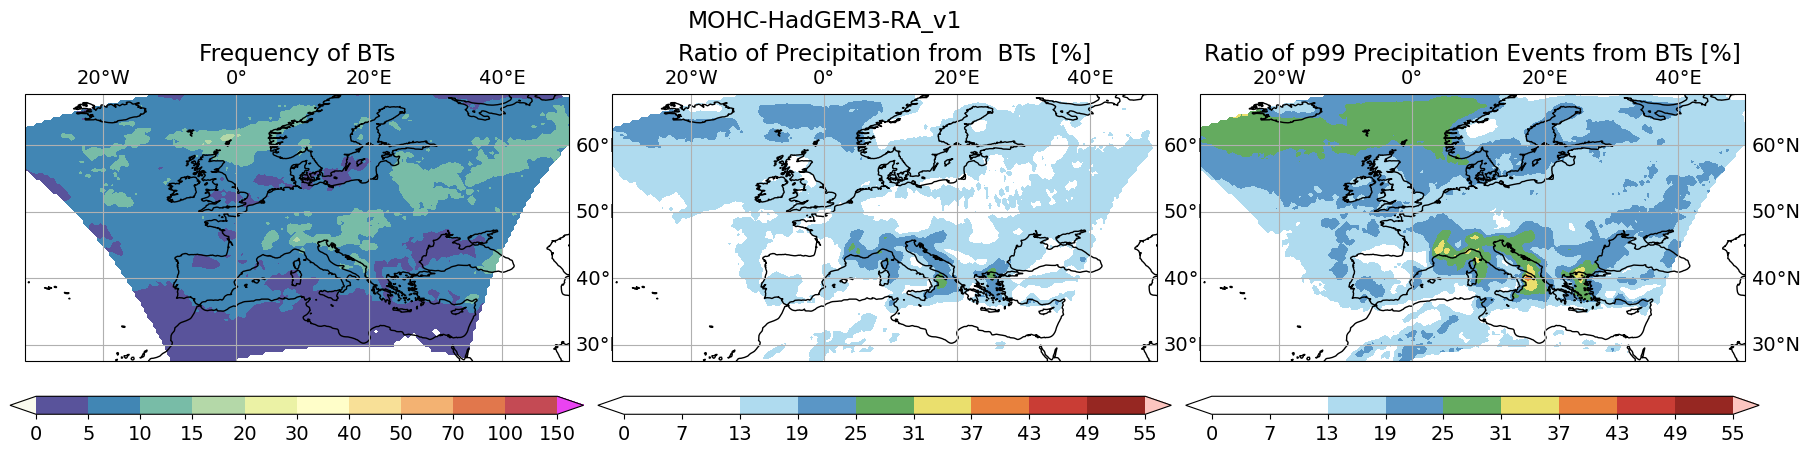

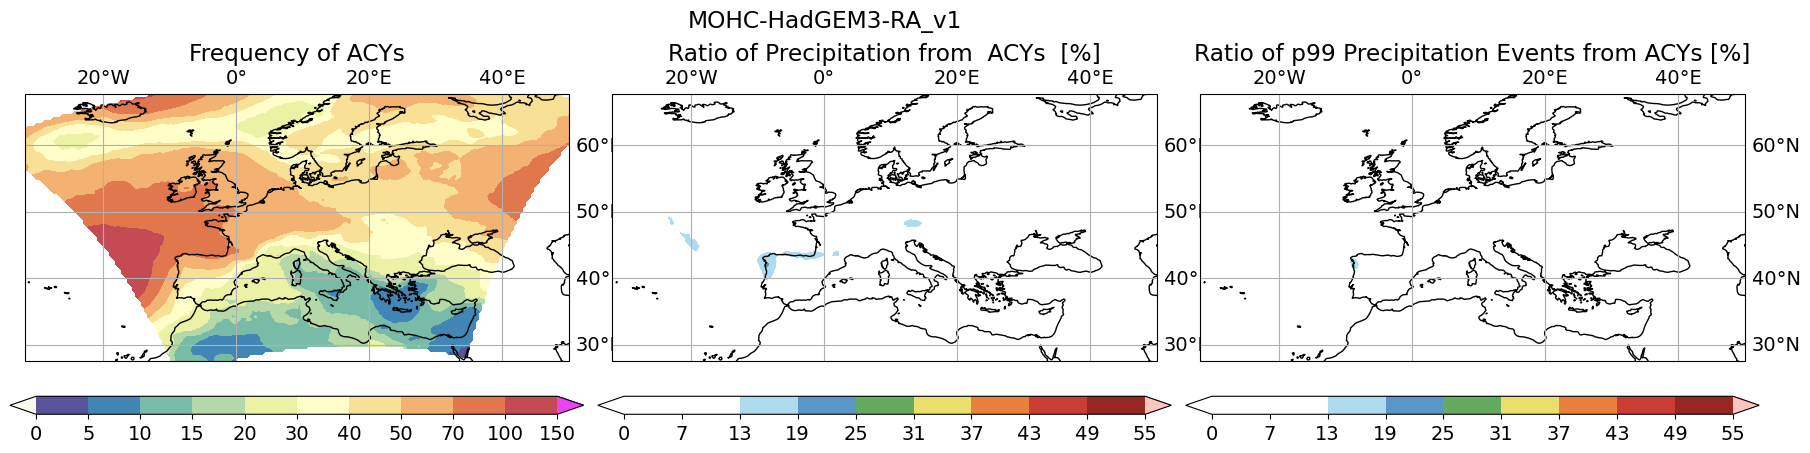

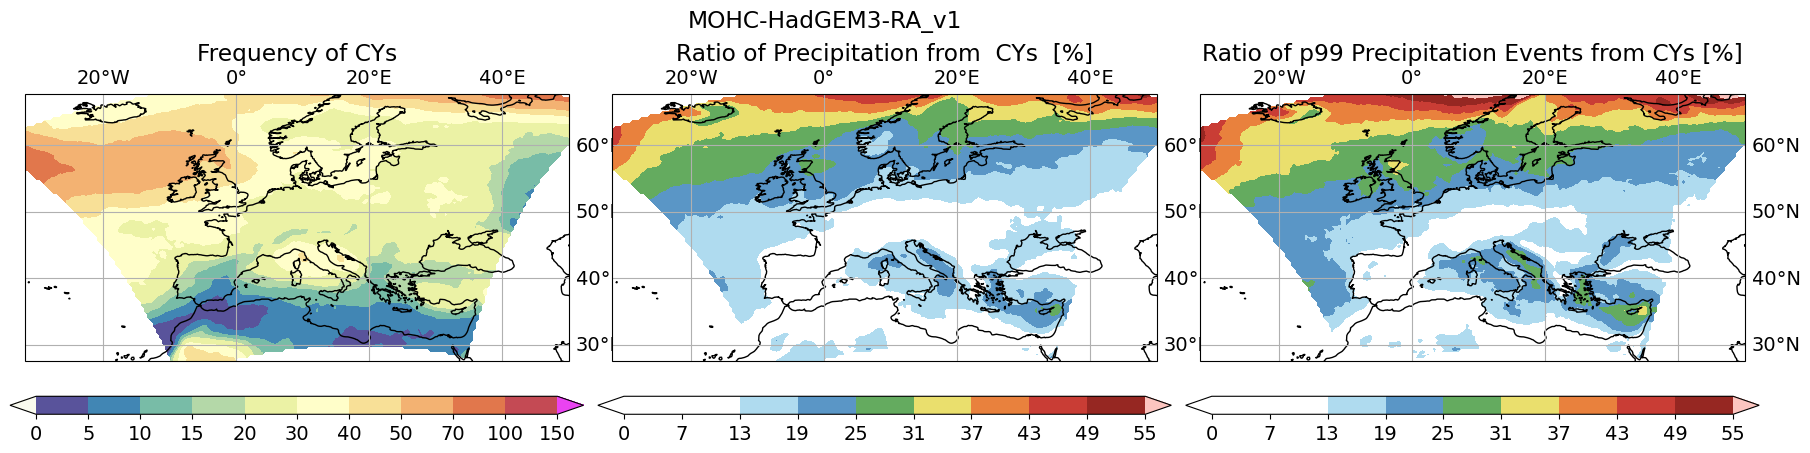

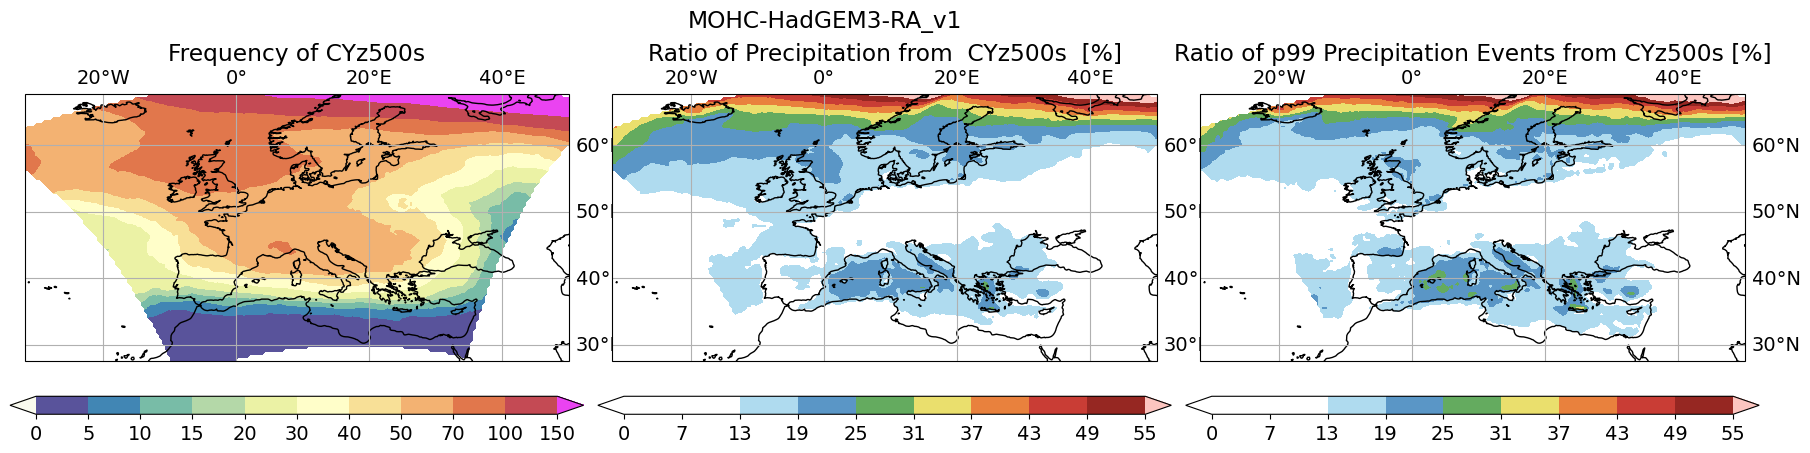

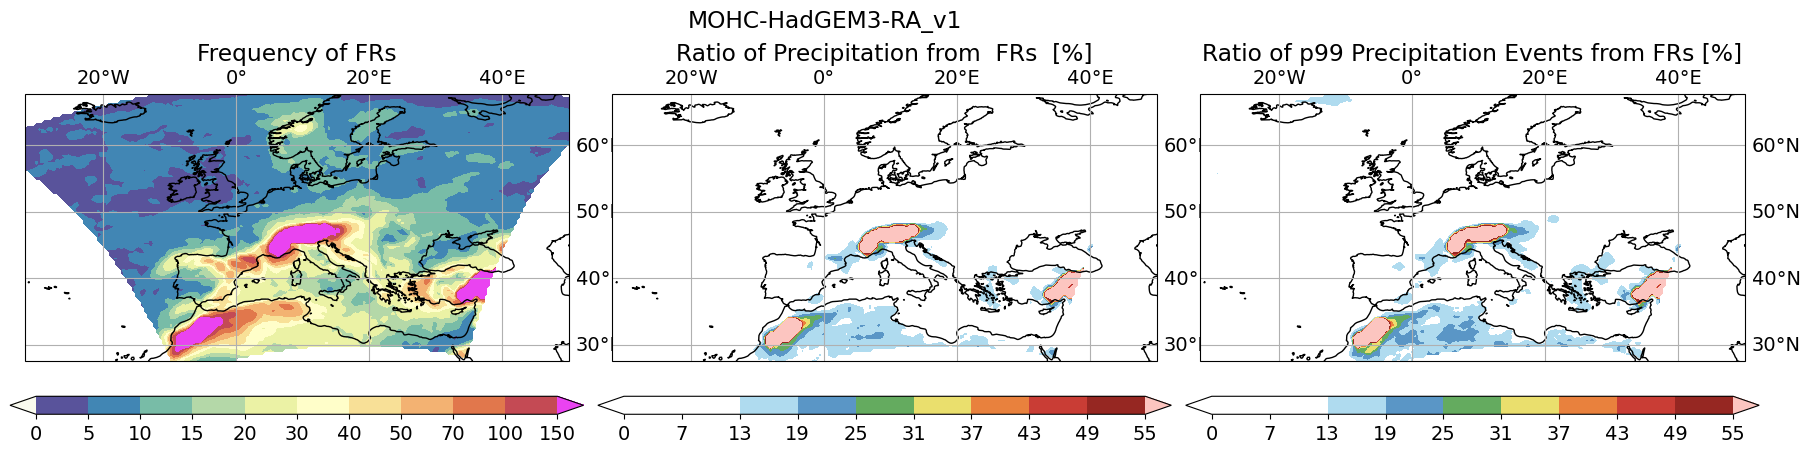

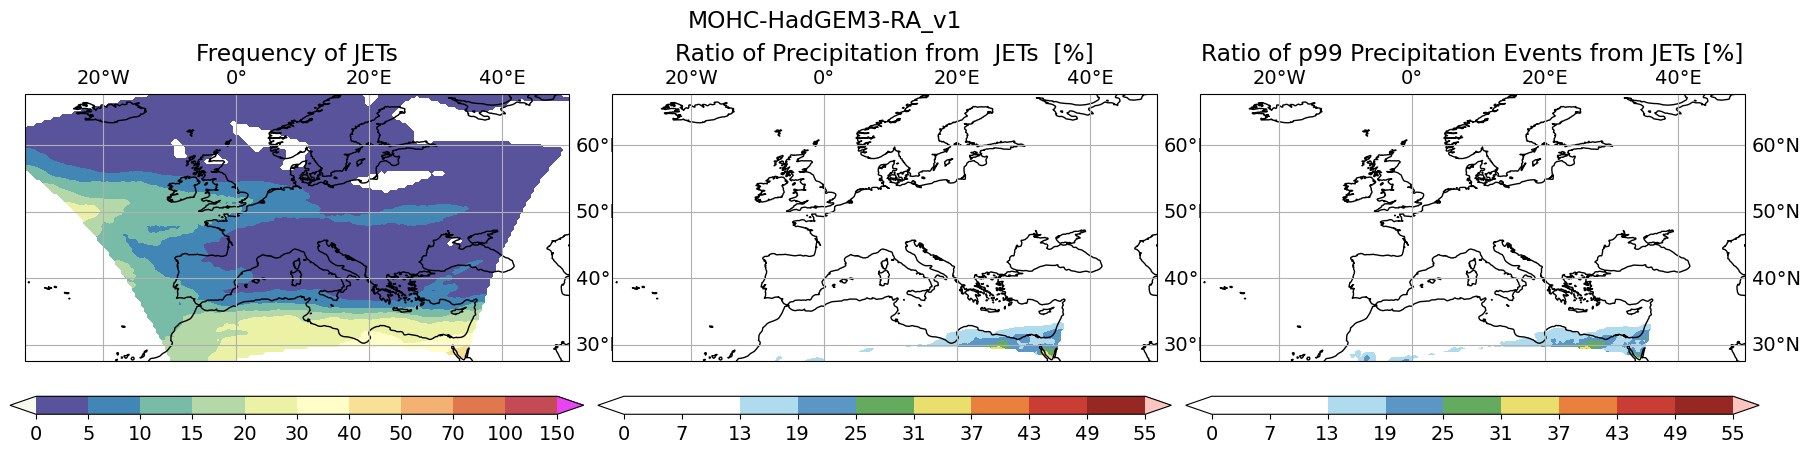

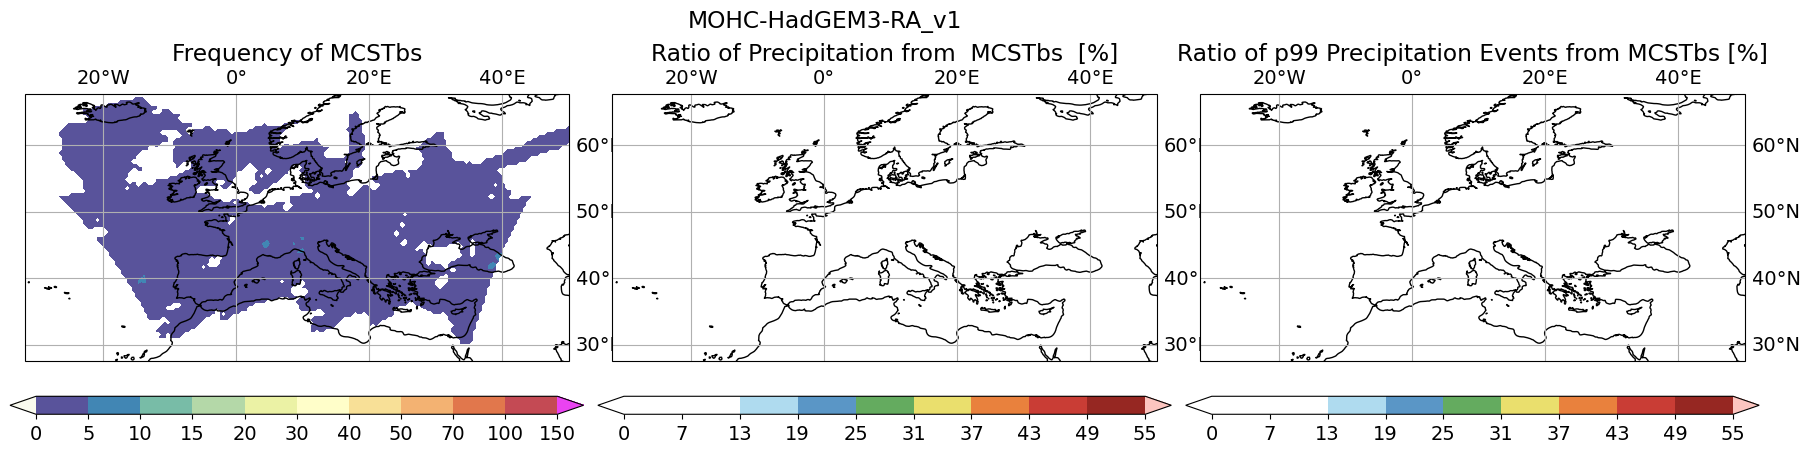

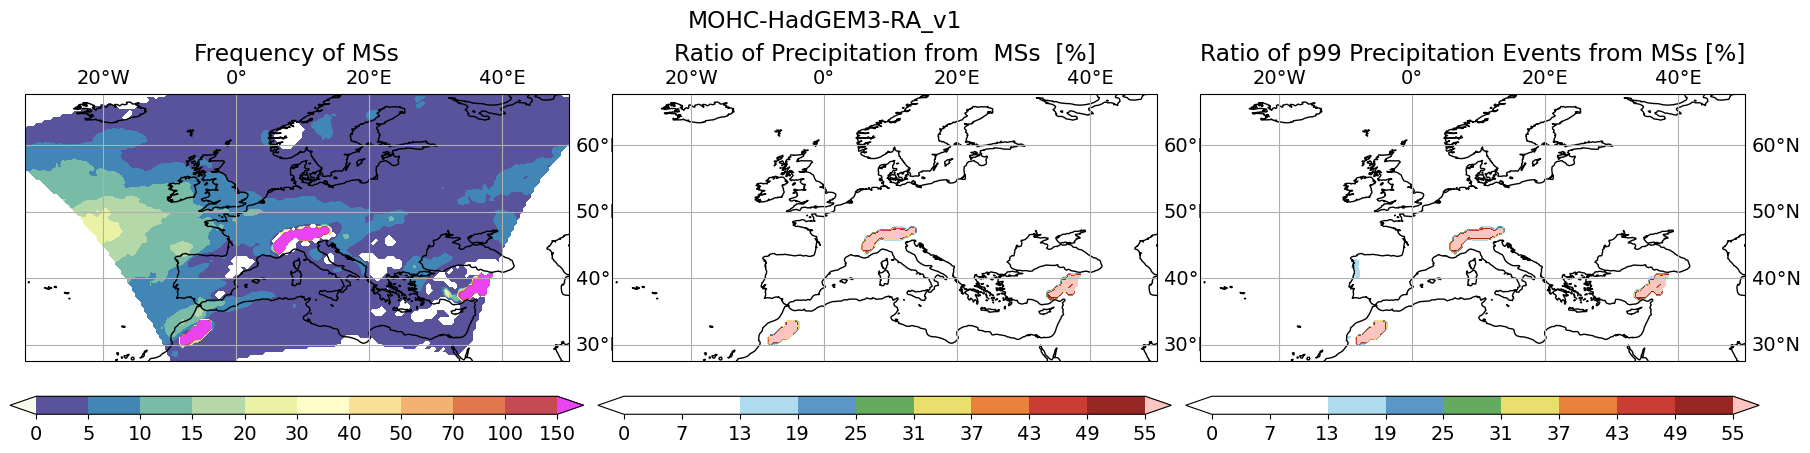

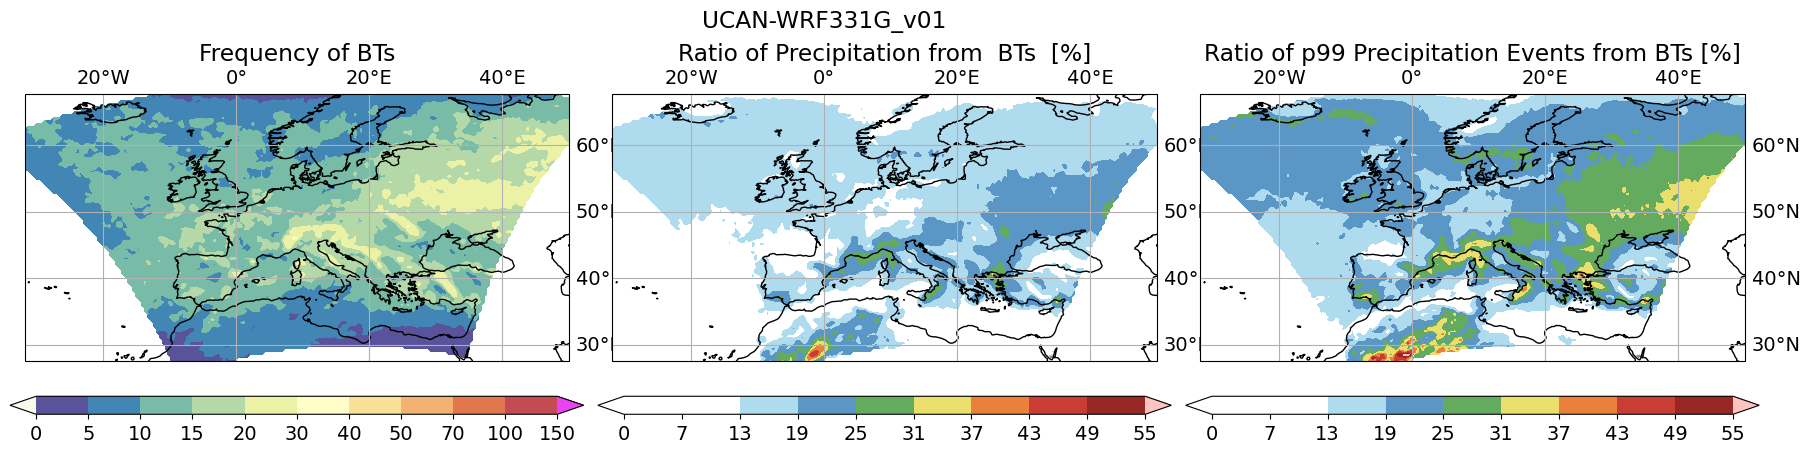

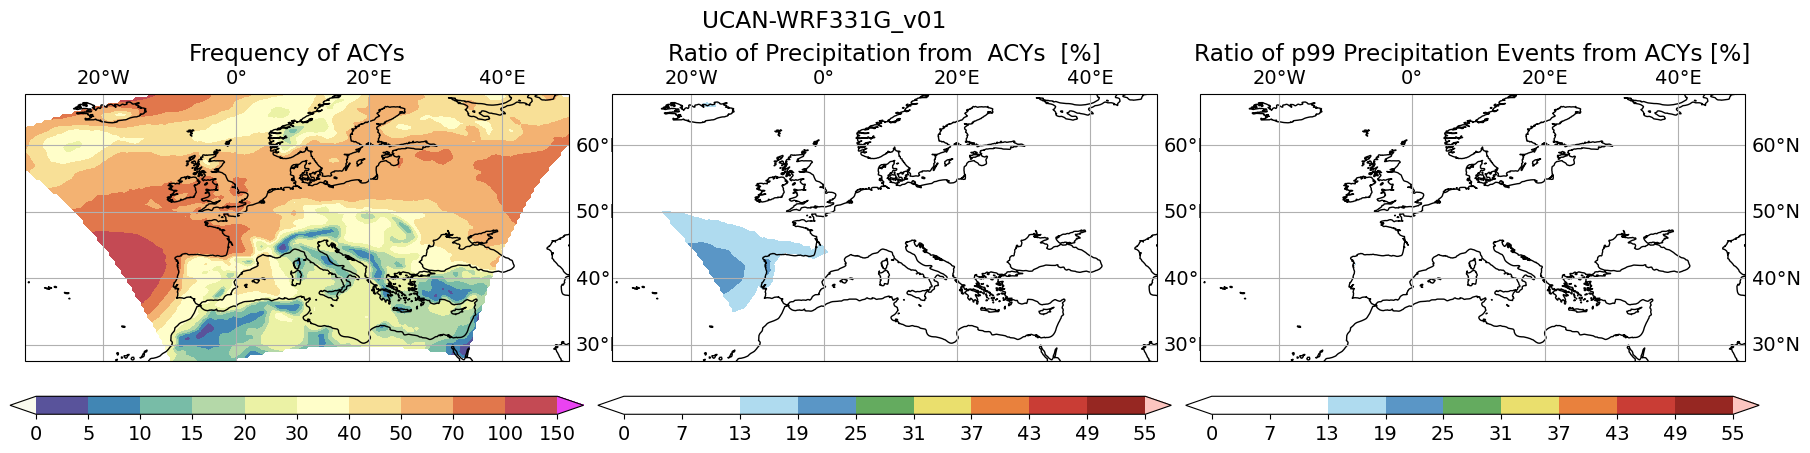

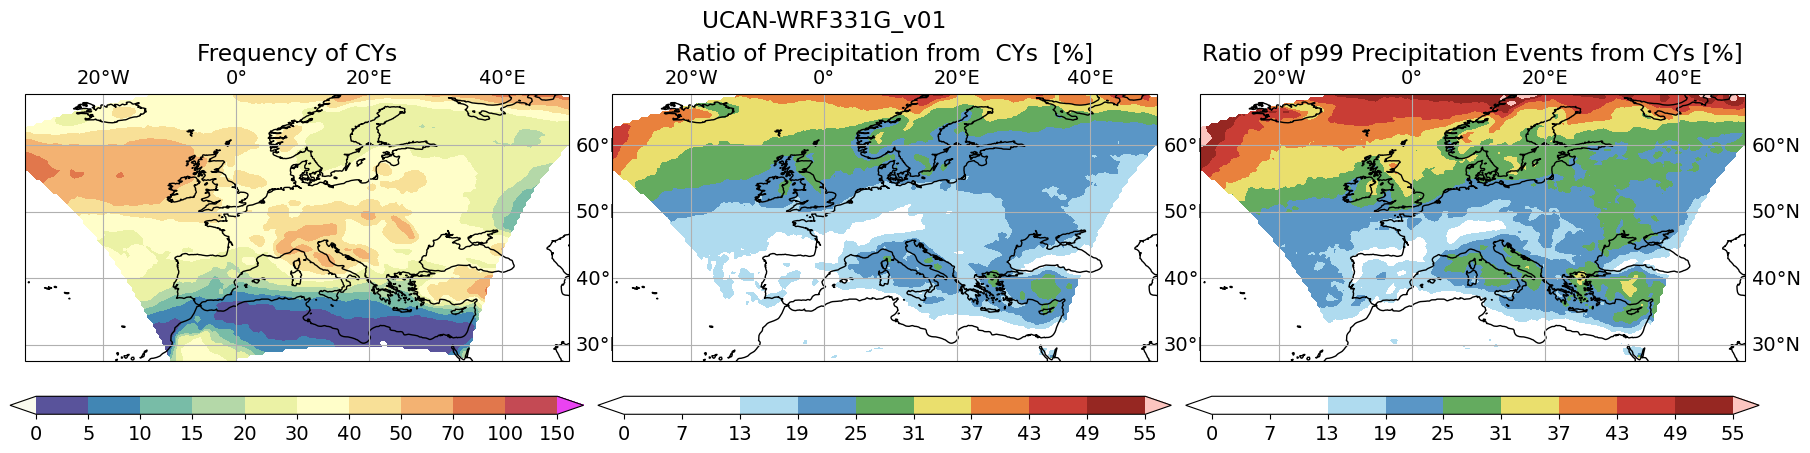

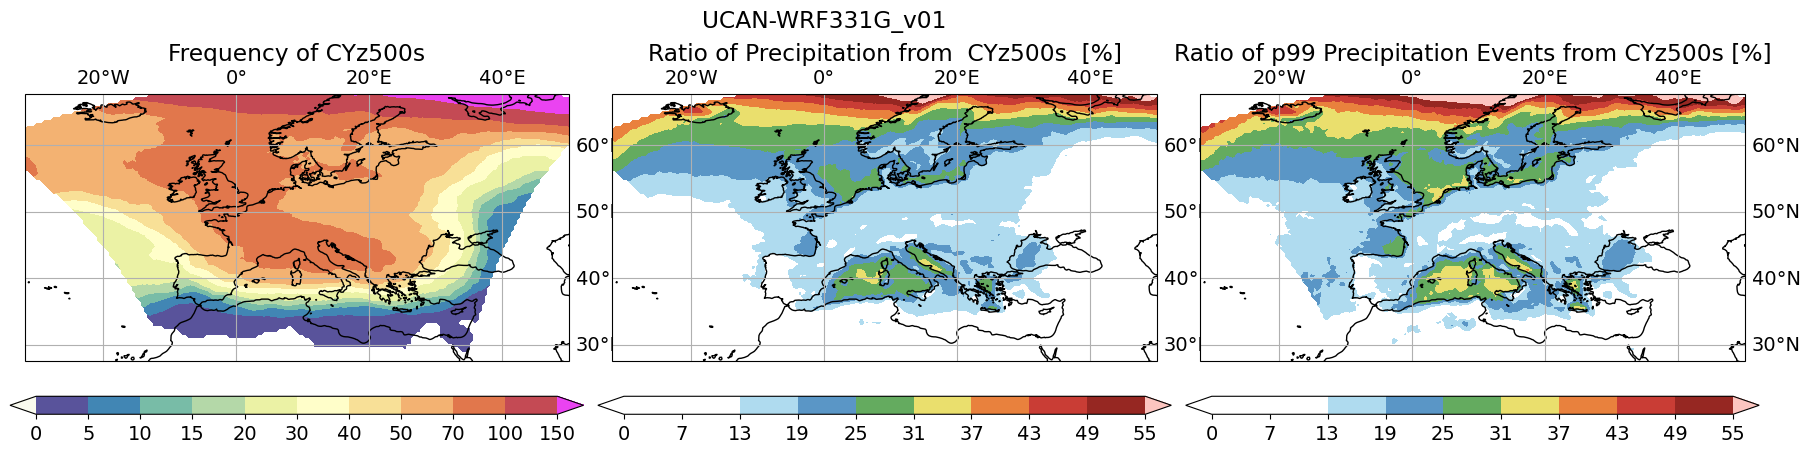

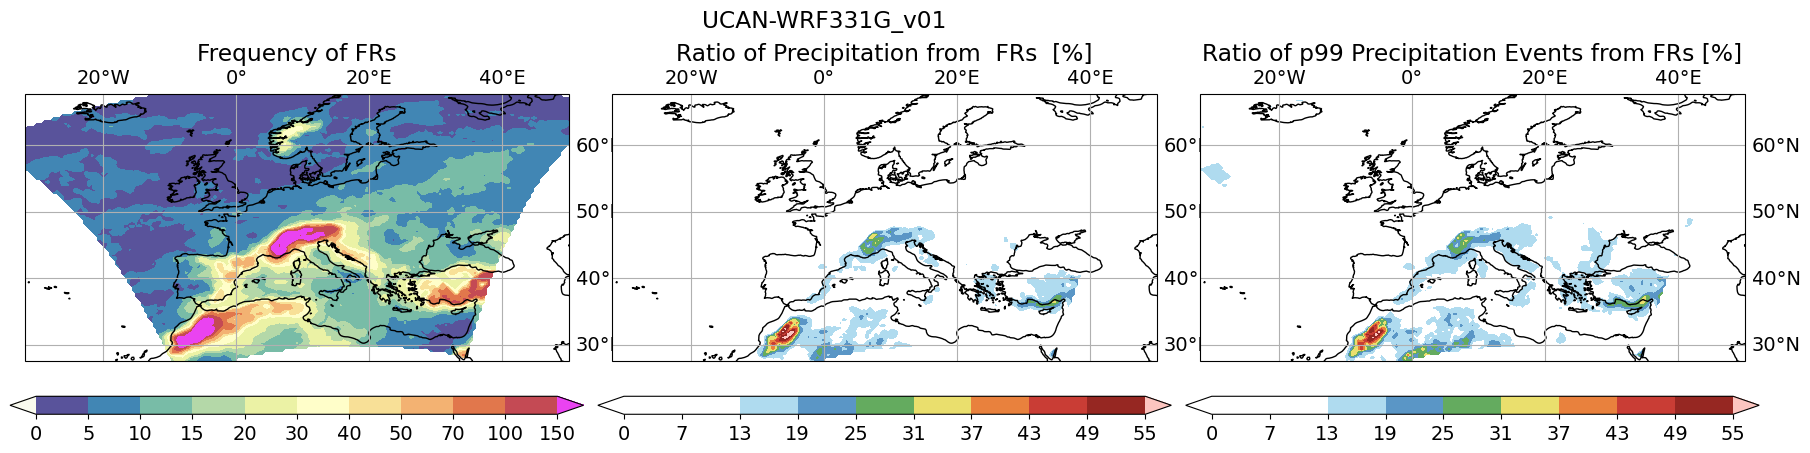

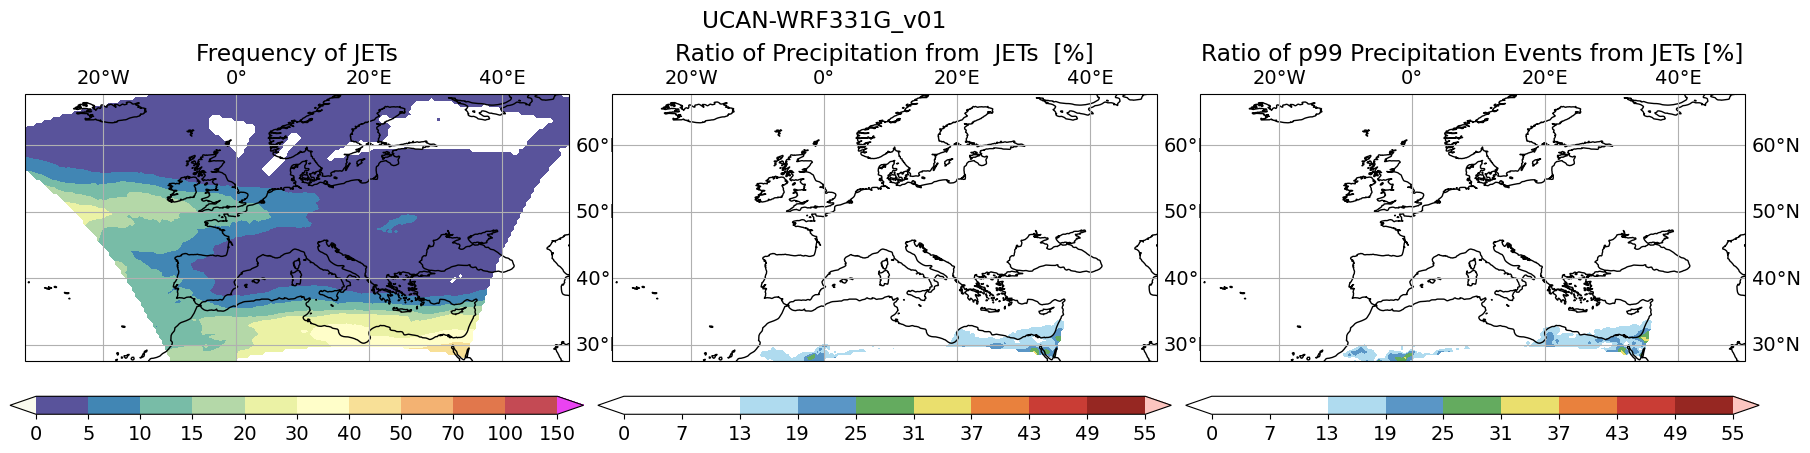

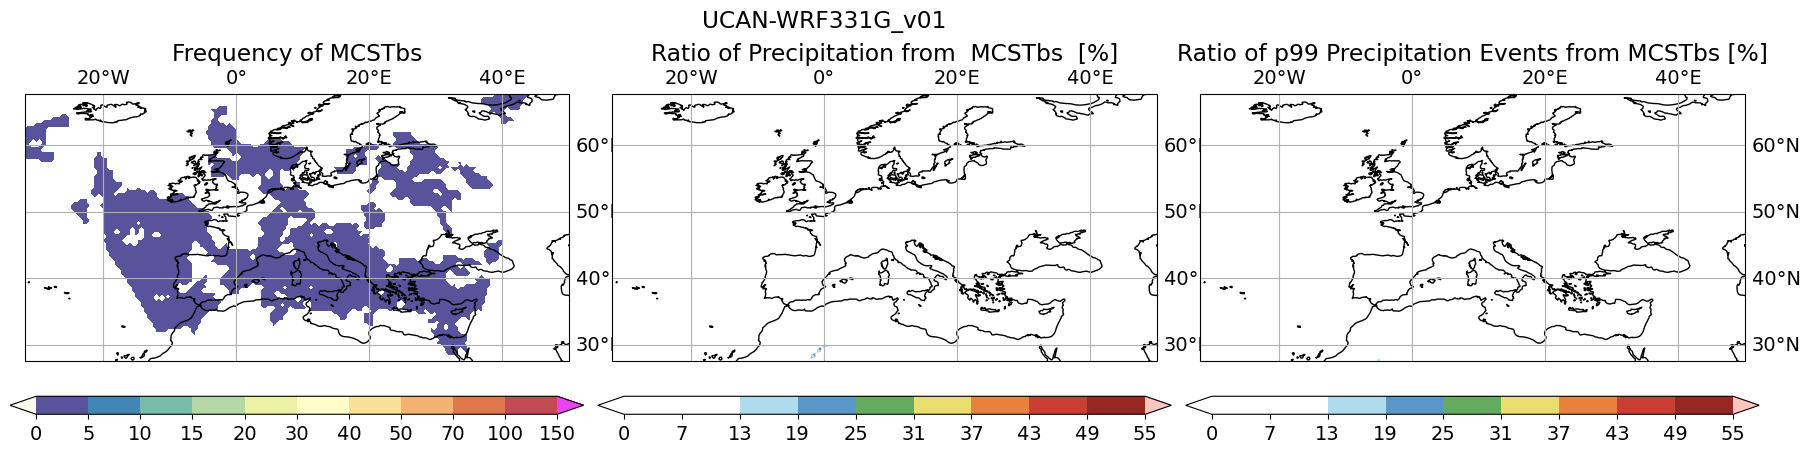

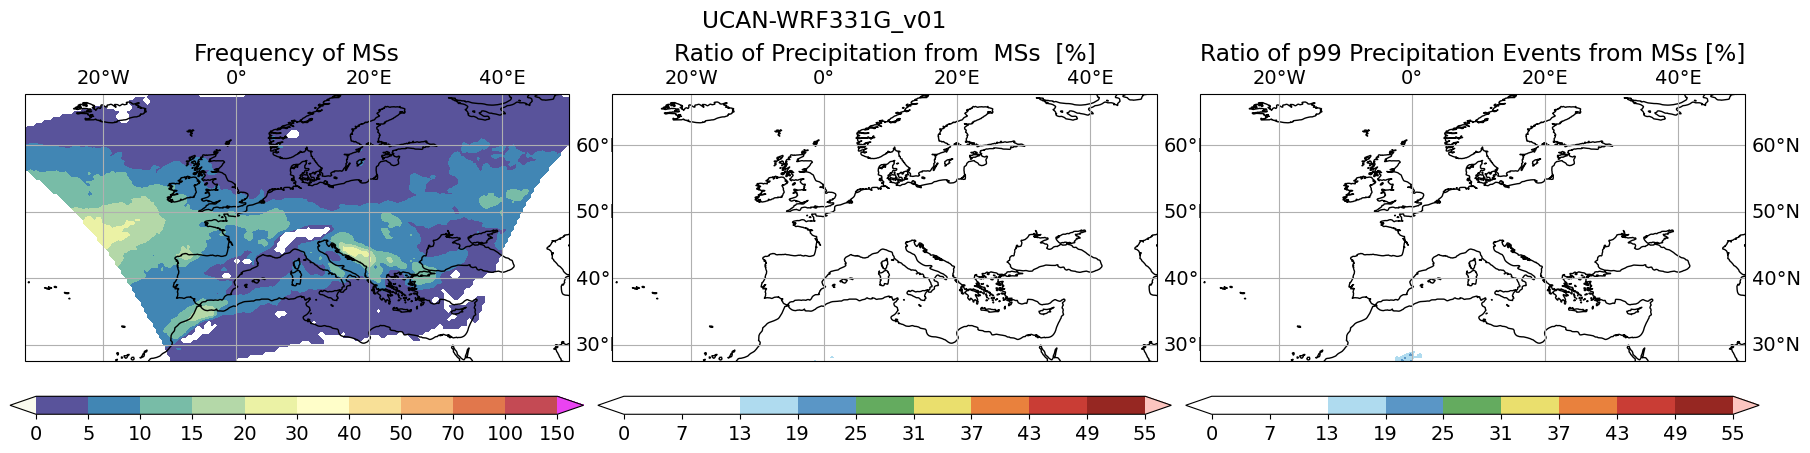

In [13]:
for nd in range(n_dataset):
    for no in range(n_obj):
        if obj_1d[no].split('_')[1] == 'Objects':
            obj_name = obj_1d[no].split('_')[0]
        else:
            obj_name = obj_1d[no].split('_')[0] +  obj_1d[no].split('_')[1]
     
        if  obj_name == 'CY' and no ==1:
             obj_name = 'surface CY'
        
        ObjectsSort = [obj_name +'s', obj_name + '_PR', obj_name + '_EPR'] 
        AnnualObjFrequency[nd,no][Mask == 0] = np.nan
        plot_ext_p3(DataName_1d[nd],ObjectsSort, AnnualObjFrequency[nd,no], data_collection[nd, no])

#### CERRA

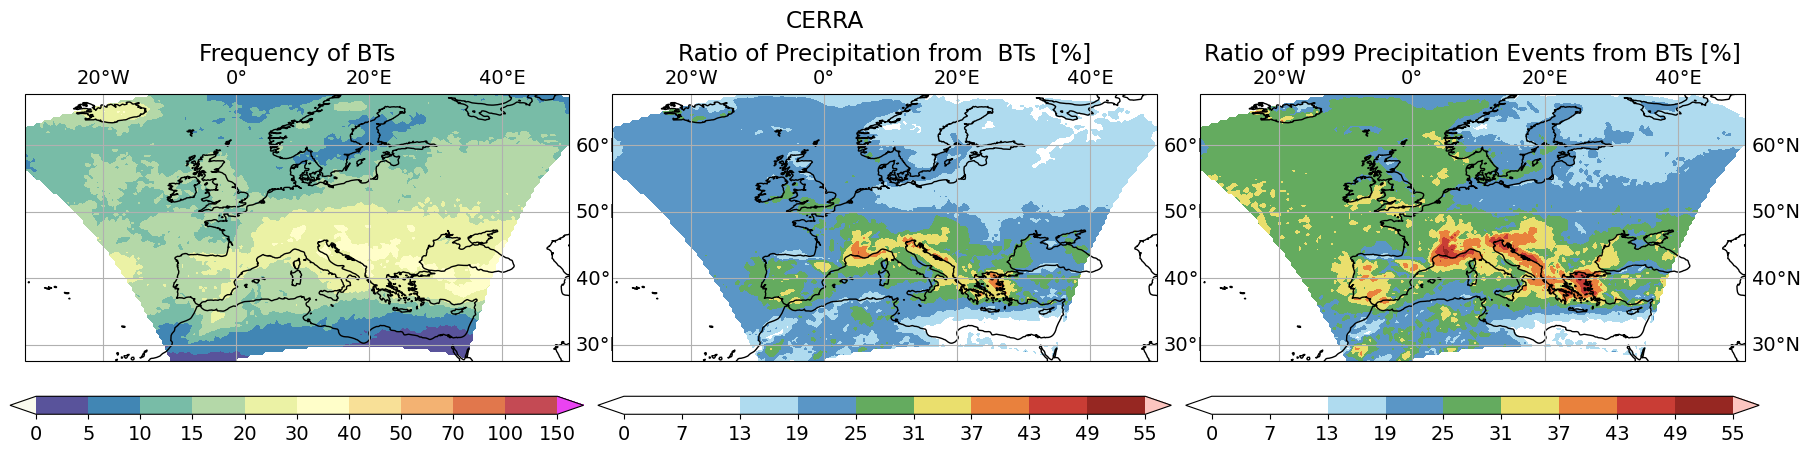

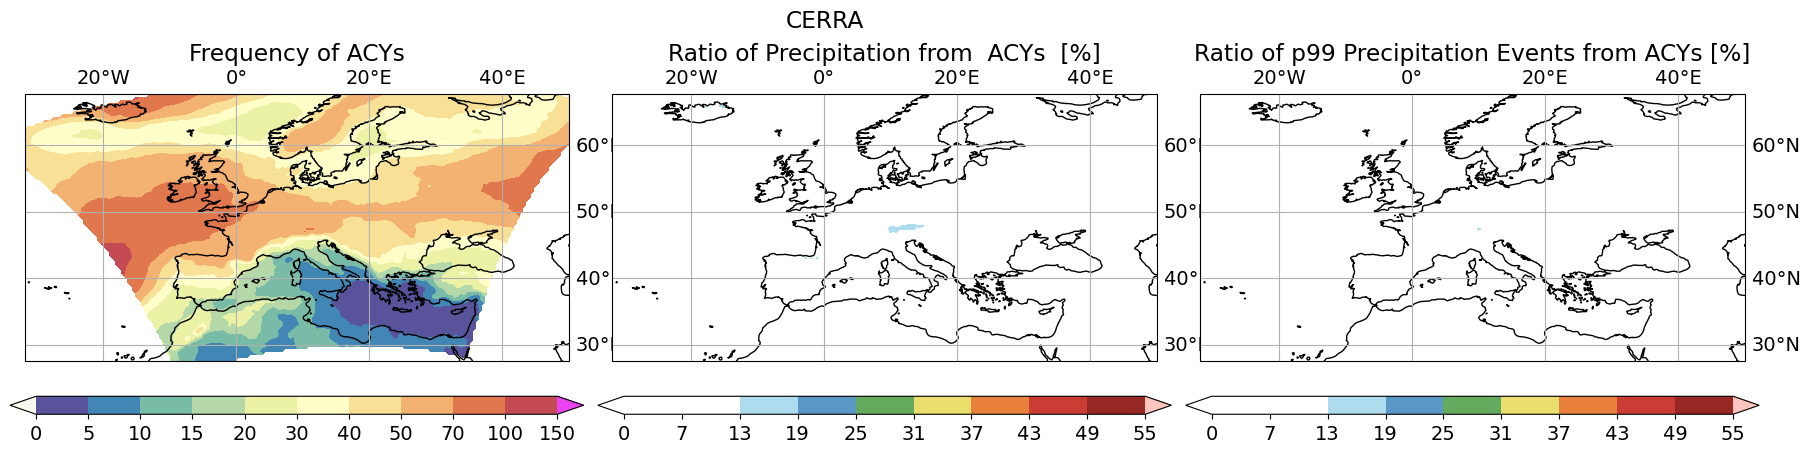

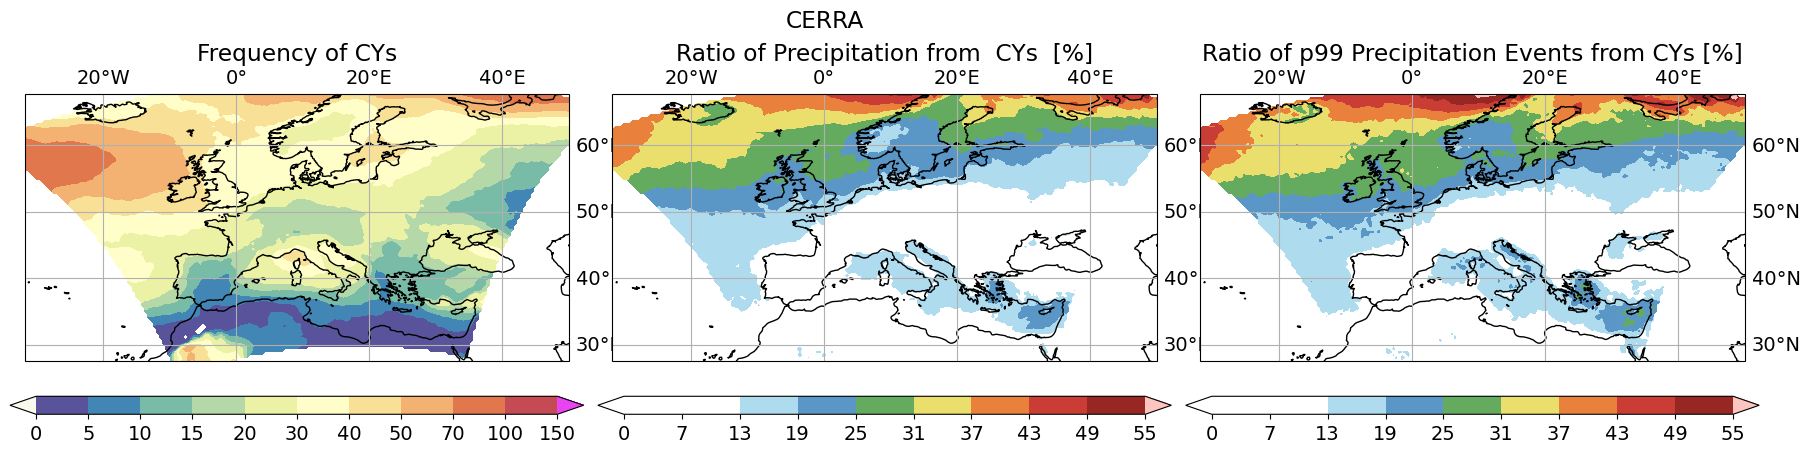

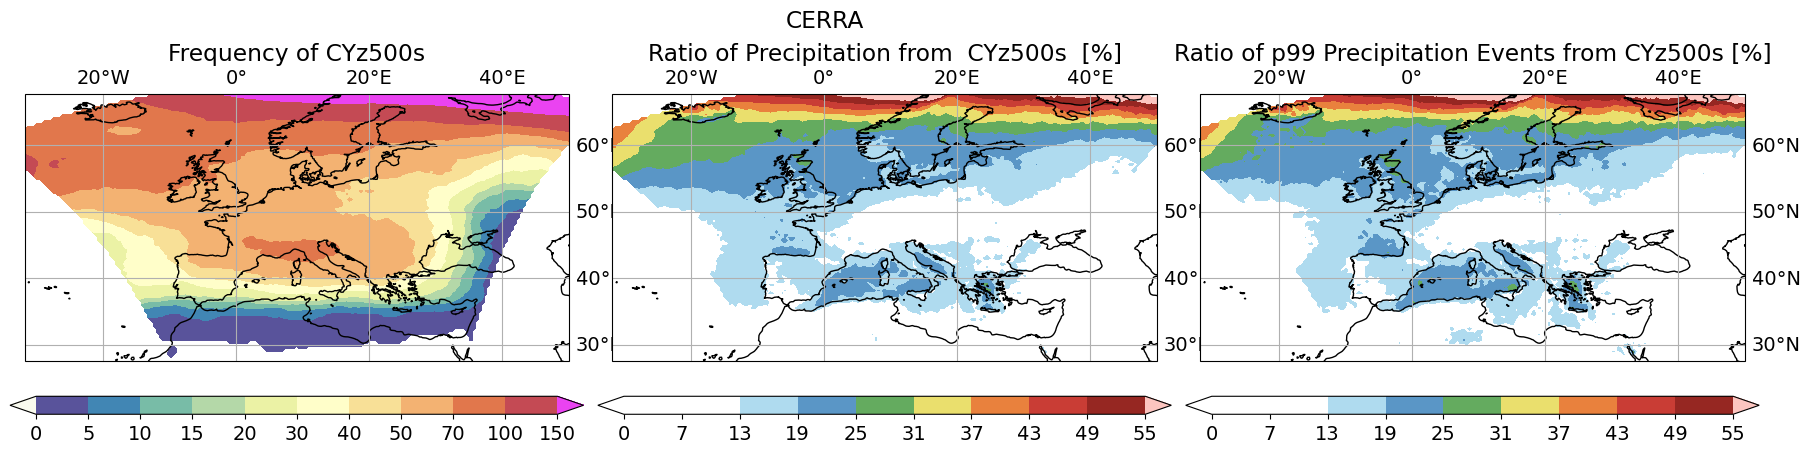

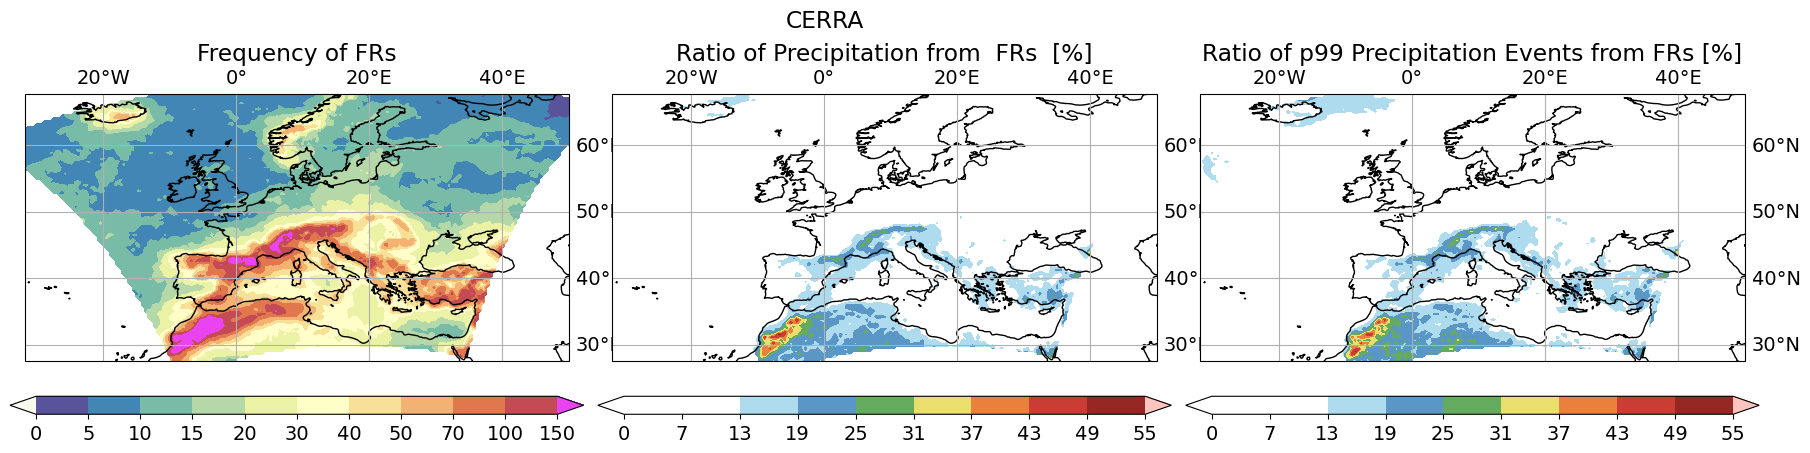

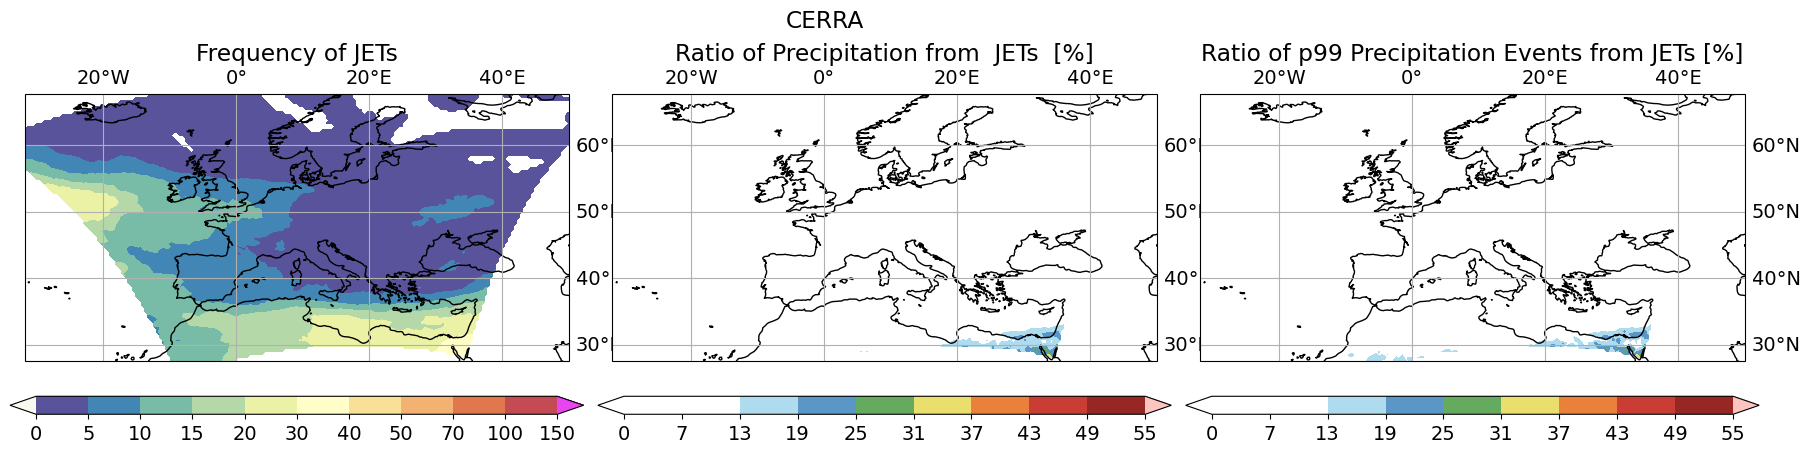

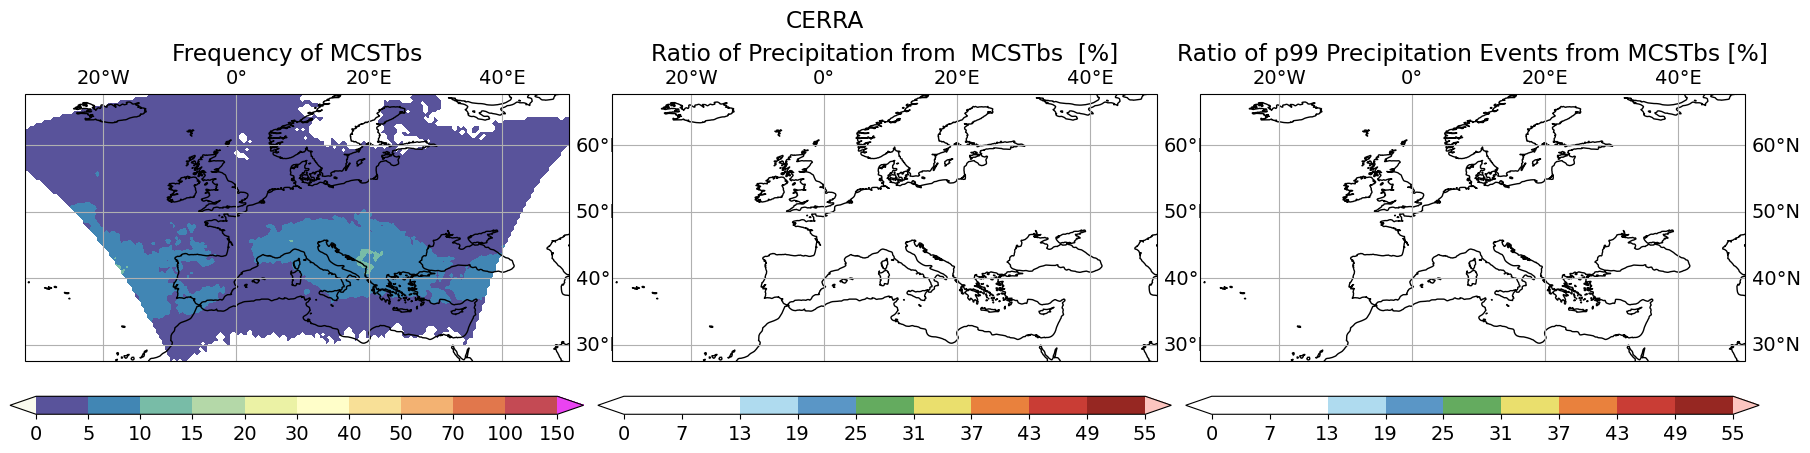

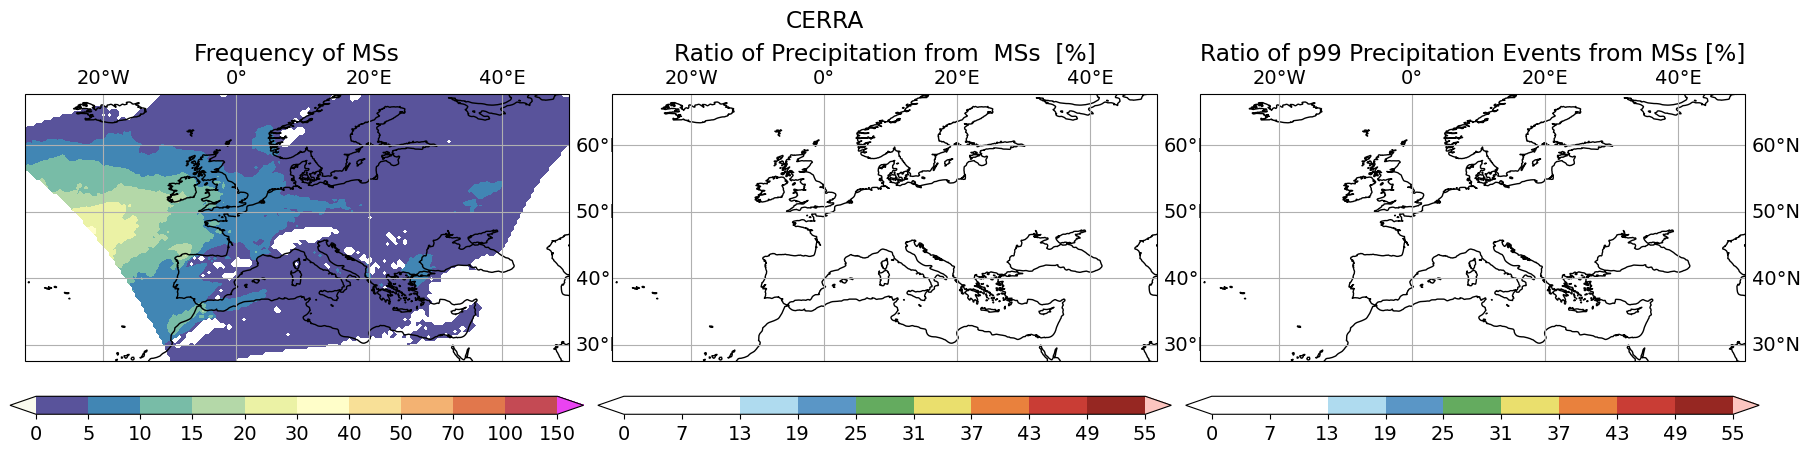

In [16]:
for nd in range(n_dataset):
    for no in range(n_obj):
        if obj_1d[no].split('_')[1] == 'Objects':
            obj_name = obj_1d[no].split('_')[0]
        else:
            obj_name = obj_1d[no].split('_')[0] +  obj_1d[no].split('_')[1]
     
        if  obj_name == 'CY' and no ==1:
             obj_name = 'surface CY'
        
        ObjectsSort = [obj_name +'s', obj_name + '_PR', obj_name + '_EPR'] 
        AnnualObjFrequency[nd,no][Mask == 0] = np.nan
        plot_ext_p3(DataName_1d[nd],ObjectsSort, AnnualObjFrequency[nd,no], data_collection[nd, no])
 